# **IT8x20 Special Topic in Information Technology (Machine Learning and AI)**

# Assignment 3

**Objective:** the objective is to correctly understand and classify images based on the below training sessions.

This is the text output for Assignment 03

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Binary Classification with MobileNetV2
For this assignment we used the tutorial, that showed how to conduct a Binary classification using transfer learning on MobileNetV2 to classify images of daisies and dandelions.

From this notebook we will be using the Daisies and Dandelions dataset which can be found [here](https://public.roboflow.com/classification/flowers_classification/1). This dataset is a collection of 1821 images images in 2 different classes. This tutorial is based on Tensorflow's [Transfer Learning on MobileNetV2 notebook](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb).

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [How to Train MobileNetV2 On a Custom Dataset](blog.roboflow.com/how-to-train-mobilenetv2-on-a-custom-dataset/) concurrently.

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Data Preprocessing
### Data Download

https://public.roboflow.com/ds/rA12vZSqku?key=OFTyC5npDU


In [ ]:
!curl -L "https://public.roboflow.com/ds/Fju1zkZt28?key=ezPk3GbwaX" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd /content/
%mkdir images/
%mv train images/train
%mv test images/test
%mv valid images/valid

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   894  100   894    0     0   3576      0 --:--:-- --:--:-- --:--:--  3576
100 27.6M  100 27.6M    0     0  34.4M      0 --:--:-- --:--:-- --:--:-- 79.7M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/ck0kcoc8ik6ni0848clxs0vif_jpeg.rf.8b4629777ffe1d349cc970ee8af59eac.jpg  
 extracting: test/images/ck0kd4afx8g470701watkwxut_jpeg.rf.bb5a1f2c2b04be20c948fd3c5cec33ff.jpg  
 extracting: test/images/ck0kdhymna0b10721v4wntit8_jpeg.rf.a08e34d04fb672ce6cf8e94e810ec81d.jpg  
 extracting: test/images/ck0kepbs9kdym0848hgpcf3y9_jpeg.rf.d0a63becb54a83b6b026f4b38a42933b.jpg  
 extracting: test/images/ck0kewsaha6hh07215jgx1bp2_jpeg.rf.1a375d20560d0de016bb524921f7b2a9.jpg  
 extracting:

In [ ]:
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder('images/')
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_test = builder.as_dataset(split='test', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='/root/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=74, num_shards=1>,
        'train': <SplitInfo num_examples=516, num_shards=1>,
        'valid': <SplitInfo num_examples=147, num_shards=1>,
    },
    citation="""""",
)


In [ ]:
print ("Train images in total are: " + str(len(raw_train)))
print ("Valid images in total are: " + str(len(raw_valid)))
print ("Test images in total are: " + str(len(raw_test)))

Train images in total are: 516
Valid images in total are: 147
Test images in total are: 74


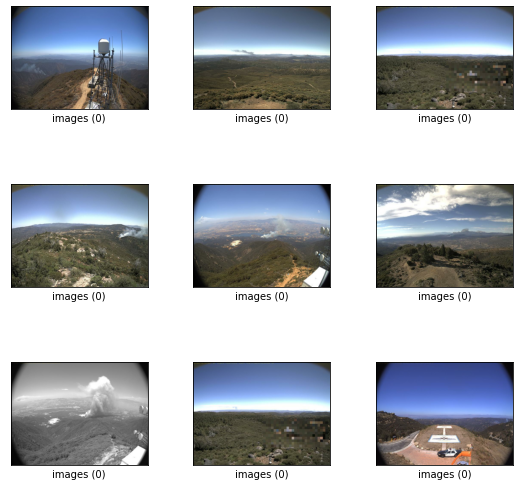

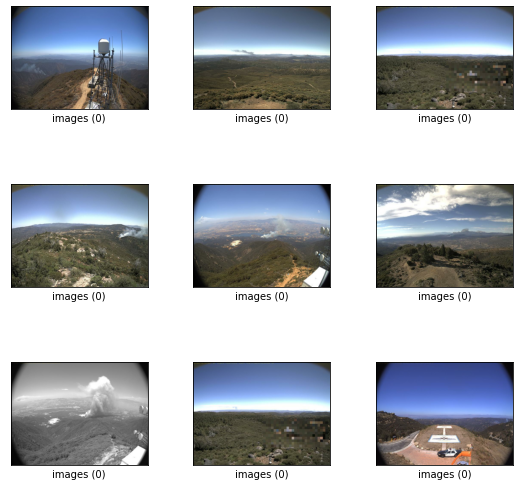

In [ ]:
tfds.show_examples(raw_train, builder.info)

### Format the Data

In [ ]:
IMG_SIZE = 160 #All images in the dataset will be set to 160x160 pixels

def format_example(pair):
    image, label = pair['image'], pair['label']
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_valid.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
    pass
image_batch.shape

TensorShape([32, 160, 160, 3])

### Create the base model from the pre-trained convnets

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

#Create the base model from the pre-trained model MobleNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Feature Extraction
#### Freeze the convolutional base

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Add a classification head

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
#print(prediction_batch.layer)

In [ ]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

### Compile the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

2

### Train the model

In [ ]:
initial_epochs = 20
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

 5/20 [======>.......................] - ETA: 12s - loss: 0.4846 - accuracy: 0.9388

20/20 [==============================] - 7s 180ms/step - loss: 0.4846 - accuracy: 0.9388


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.48
initial accuracy: 0.94


In [ ]:
history = model.fit(train_batches, epochs = initial_epochs, validation_data = validation_batches)

Epoch 1/20
17/17 [==============================] - 20s 893ms/step - loss: 0.3103 - accuracy: 0.9961 - val_loss: 0.1860 - val_accuracy: 1.0000
Epoch 2/20
17/17 [==============================] - 17s 947ms/step - loss: 0.1519 - accuracy: 1.0000 - val_loss: 0.1005 - val_accuracy: 1.0000
Epoch 3/20
17/17 [==============================] - 19s 974ms/step - loss: 0.0854 - accuracy: 1.0000 - val_loss: 0.0559 - val_accuracy: 1.0000
Epoch 4/20
17/17 [==============================] - 16s 891ms/step - loss: 0.0493 - accuracy: 1.0000 - val_loss: 0.0328 - val_accuracy: 1.0000
Epoch 5/20
17/17 [==============================] - 14s 753ms/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.0194 - val_accuracy: 1.0000
Epoch 6/20
17/17 [==============================] - 16s 896ms/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 1.0000
Epoch 7/20
17/17 [==============================] - 17s 854ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 1.0000

### Learning curves

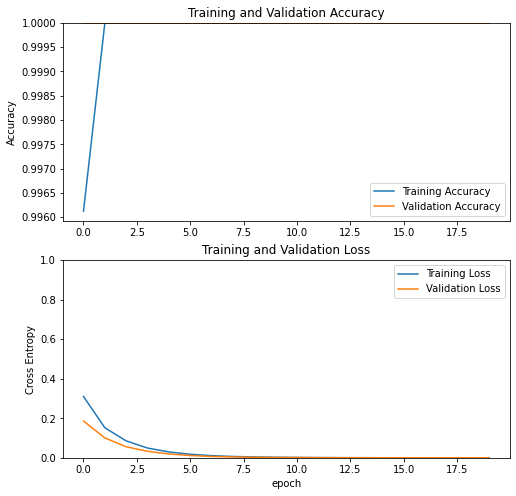

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning
### Un-freeze the top layers of the model

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]: layer.trainable = False

Number of layers in the base model:  154


### Compile the model

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate / 10), metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

56

### Continue training the model

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches, epochs = total_epochs, initial_epoch = history.epoch[-1],
                         validation_data = validation_batches)

Epoch 20/30
17/17 [==============================] - 36s 2s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 8.2709e-05 - val_accuracy: 1.0000
Epoch 21/30
17/17 [==============================] - 26s 1s/step - loss: 8.8656e-04 - accuracy: 1.0000 - val_loss: 8.6140e-05 - val_accuracy: 1.0000
Epoch 22/30
17/17 [==============================] - 25s 1s/step - loss: 7.7006e-04 - accuracy: 1.0000 - val_loss: 8.9661e-05 - val_accuracy: 1.0000
Epoch 23/30
17/17 [==============================] - 24s 1s/step - loss: 6.8453e-04 - accuracy: 1.0000 - val_loss: 9.1959e-05 - val_accuracy: 1.0000
Epoch 24/30
17/17 [==============================] - 22s 1s/step - loss: 6.3880e-04 - accuracy: 1.0000 - val_loss: 9.3243e-05 - val_accuracy: 1.0000
Epoch 25/30
17/17 [==============================] - 26s 1s/step - loss: 5.6435e-04 - accuracy: 1.0000 - val_loss: 9.4035e-05 - val_accuracy: 1.0000
Epoch 26/30
17/17 [==============================] - 23s 1s/step - loss: 5.3243e-04 - accuracy: 1.0000 - val_l

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

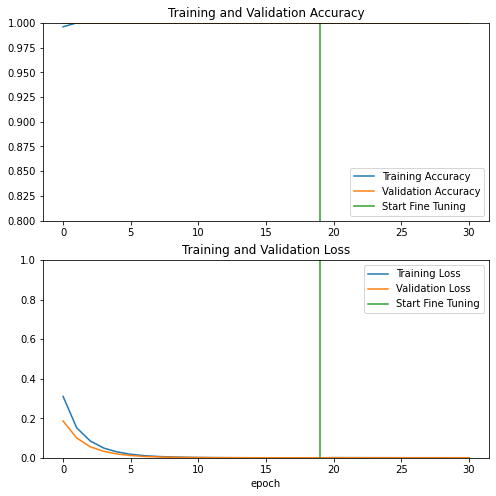

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Infer on a Sample Image

1/1 [==============================] - 1s 938ms/step


Text(0.5, 1.0, 'Daisy')

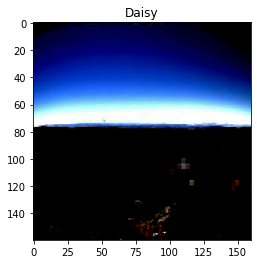

In [ ]:
test_batches = test.batch(1)
for image, label in test_batches.take(1): pass
plt.imshow(np.squeeze(image))
plt.title("Dandelion" if model.predict(image) > 0 else "Daisy")

## Summary:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.